# Multiagent Tennis - Competitive Solved Using DDPG
### Udacity Project Submission by Jayanth Nair
This notebook walks through the implementation of the vanilla DDPG algorithm to solve the UnityML Tennis Environment (2 agents competing against each other)

This solution utilizes a common actor-critic network shared by both agents

In [1]:
# necessary imports to get environment up and running
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### DDPG Implementation Details

#### Neural Network Architecture
The DDPG network used in this notebook consists of common actor-critic networks.  The actor contains 3 fully connected layers and 1 output layer(24x128x64x2) with ReLU activation of the input and hidden layers.  The weights are initialized according to the DDPG paper

The critic contains 3 fully connected layers and 1 output layer (24x128x64x1) with ReLU activation of input and hidden layers.

The common actor-critic network utilizes an experience replay buffer where observations from both competing agents are stored

#### Hyper-parameters

|Hyper-parameter |Value |
|:-------------- |:---- |
|Replay Buffer Size | 1000000 |
|Batch Size | 512 |
|Discount Factor | 0.99 |
|Learning Rate-Actor | 0.0001 |
|Learning Rate-Critic | 0.0001 |
|L2 Weight Decay | 0 |
|Update Network Every _ Steps | 1|
|Learn For _ Times | 1 |


In [6]:
# import modules
import torch
%load_ext autoreload
%aimport ddpg_multiagent 
from ddpg_multiagent import Agent
import matplotlib.pyplot as plt
from collections import deque

In [7]:
n_agents=states.shape[0] # number of agents 

In [8]:
# initializing agent
agent = Agent(state_size=state_size,action_size=action_size,random_seed=0,n_agents=n_agents)

In [9]:
def ddpg_multiagent(n_agents, n_episodes=10000, max_t=1000, print_every=100):
    '''
    Function which runs the training process 

    Arguments:
     n_agents (int) : Number of agents
     n_episodes (int): Max number of episodes to run training
     max_t (int): Max time steps in each episode
     print_every (int): Printing summarized results every x episodes
 
    Returns :
     scores (list): List of averaged scores over all agents for each episode 


    '''
    scores_deque = deque(maxlen=100)
    scores = []
    best_score = 0.
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        agent_scores = np.zeros(n_agents)
        for t in range(max_t):
            actions = [agent.act(states[agent_id], agent_id) for agent_id in range(n_agents)]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for agent_id in range(n_agents):
                agent_scores[agent_id] += rewards[agent_id]
                agent.step(states[agent_id], actions[agent_id], rewards[agent_id], 
                           next_states[agent_id], dones[agent_id], agent_id)
            states = next_states
            if np.any(dones):
                break
        score = np.max(agent_scores)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(i_episode, round(score,2), round(np.mean(scores_deque),2)),end=" ")
        if score > best_score:
            print('\rScore of {0} better than previous best score of {1} - Saving weights!'.format(round(score,1),round(best_score,1)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = score
        if i_episode % print_every == 0:
            print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(i_episode, round(score,1), round(np.mean(scores_deque),1)))
        if score > 0.5 and np.mean(scores_deque) > 0.5:
            print('\rReacher environment with {0} agents solved in {1} episodes!'.format(n_agents,i_episode))
            break

    return scores

C:\Users\jynth\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score of 0.1 better than previous best score of 0.0 - Saving weights!0.01 
Episode # - 16,	Average Score - 0.0,	Average Score over 100 Episodes-0.01 

D:\udacity_reinforcement_learning\Udacity Projects\Reinforcement-Learning-Nanodegree\p3_collab-compet\ddpg_multiagent.py:118: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1) #clipping gradients as per tips from Udacity


Episode # - 100,	Average Score - 0.0,	Average Score over 100 Episodes-0.01 
Episode # - 200,	Average Score - 0.0,	Average Score over 100 Episodes-0.0   
Episode # - 300,	Average Score - 0.0,	Average Score over 100 Episodes-0.0  
Episode # - 400,	Average Score - 0.0,	Average Score over 100 Episodes-0.0  
Episode # - 500,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 600,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 700,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 800,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 900,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 1000,	Average Score - 0.0,	Average Score over 100 Episodes-0.0 
Episode # - 1100,	Average Score - 0.0,	Average Score over 100 Episodes-0.03  
Score of 0.2 better than previous best score of 0.1 - Saving weights!s-0.05  
Episode # - 1200,	Average Score - 0.1,	Average Score over 100 Episodes-0.16 
Episode # -

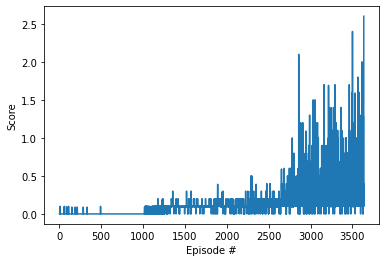

In [10]:
scores = ddpg_multiagent(n_agents)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [11]:
env.close()